# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import time
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

# 2. Preprocessing

## 2.1 Import the text data

In [2]:
df = pd.read_csv('../dataset/kpop.csv')

In [3]:
df.fillna('blank', inplace=True)

## 2.2 Splitting training and test dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['class'],
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = df['class'])

In [5]:
train_index = X_train.index

In [6]:
test_index = X_test.index

## 2.3 Initiate and fit Tfidf

From here we took our cleaned text, vectorized and normalized the matrix using sklearn’s TFIDFTransformer, this will allow our data to be ready to input into a model. Consider the size of data is pretty large, we can tune the parameters `min_df` in TFIDFTransformer:

`min_df`is used for removing terms that appear too infrequently. For example:<br>
        
        min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
        The default min_df is 1, which means "ignore terms that appear in less than 1 document". 
In here, we set the min_df=50 to remove terms that appear in less than 50 documents.

In [7]:
tfidf = TfidfVectorizer(min_df=50, max_df=.95 , ngram_range=(1,2))

In [8]:
X_train = tfidf.fit_transform(X_train)

## 2.4 Vectors to SparseDataFrame

In [9]:
X_train = pd.SparseDataFrame(X_train, columns=tfidf.get_feature_names(), index = train_index)
X_train.head()

,ability,able,absolute,absolutely,acapella,accepted,access,accident,accidentally,according,...,틴탑,펜타곤,포미닛,포텐,프로미스나인,피에스타,헤일로,현아,효린,히스토리
69265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vectorized the text creating a very sparse word count matrix that contained 4700 features. “Sparse” versions of DataFrame allow us to view these objects as being “compressed” where any data matching a specific value (zero in this case) is omitted. This sparse object takes up much less memory on disk and in the Python interpreter. Functionally, their behavior should be nearly identical to their dense counterparts.

In [10]:
X_train.fillna(0, inplace=True)

We can fill NAN values with '0' in the SparseDataFrame.

In [11]:
X_test = pd.SparseDataFrame(tfidf.transform(X_test), columns=tfidf.get_feature_names(),index = test_index)
X_test.fillna(0, inplace=True)

Apply the same procedures to transform test dataset with the fitted "TFIDFTransformer".

## 2. Modeling

## 2.1 Baseline Accuracy

In [12]:
y_train.value_counts(normalize=True)

0    0.512761
1    0.487239
Name: class, dtype: float64

Our Baseline model accuracy is 51.2%, we should build the classifier to beat the baseline accuracy. The purpose of this classification model is rather to find the most important text features with fairy acceptable accuracy than to produce the high accuracy classification model. Hence, we picked the easily interpretable classification models Logistic Regression and Random Forest Classifiers. 

## 2.2 Logistic Regression

## 2.2.1 Grid Search to explore hyper-parameters

It is usually difficult to know in advance what hyper parameters will enable a model to make better predictions, Model hyper-parameters are values that get defined before training a dataset and can not be learned directly from the data. For every model there are many hyper-parameters, so a good way to define the best set of hyper-parameters is by trying different combinations and comparing the results.Grid Search evaluates all the combinations from a list of desired hyper-parameters and reports which combination has the best accuracy.

In [13]:
start_time = time.time()
params_logit = {'penalty':['l1','l2'],
                'C': [0.01, 0.1, 1, 10] 
}

gs_logit = GridSearchCV(LogisticRegression(), 
                        param_grid=params_logit, 
                        return_train_score=False)
gs_logit.fit(X_train, y_train)
print("--- {}s seconds ---".format((time.time() - start_time)))

--- 446.7606751918793s seconds ---


The time took to grid search the best parameters is 448 seconds. 

In [14]:
gs_logit.best_params_

{'C': 1, 'penalty': 'l1'}

The best fitted parameters are C=1 and l1 penalty. 

In [15]:
gs_logit.score(X_train, y_train)

0.7713454850701523

In [16]:
gs_logit.score(X_test,y_test)

0.7480888569115928

Although the accuracy of Logistic Regression Classifier on training and test dataset is not that high, and the model is slightly overfitted, we still can expect this model can give us a lot of information by pulling important features. 

## 2.2.2 Most important features in the model

In [17]:
betas = pd.DataFrame(gs_logit.best_estimator_.coef_.T, 
                     index = X_train.columns, 
                     columns=['weight'])
betas['euler'] = [np.exp(beta) for beta in betas['weight']]

In [18]:
weights = betas.sort_values('euler', ascending=False)['euler'].head(20)
labels = weights.sort_values(ascending=False).index

In [19]:
weights_color = ['black','#8B0000','#8B0000','#8B0000','#8B0000','#8B0000','green','#8B0000','#3F5D7D','#8B0000','green','#8B0000','#8B0000','#8B0000','black',
'#3F5D7D','#8B0000','#8B0000','#3F5D7D','#3F5D7D']

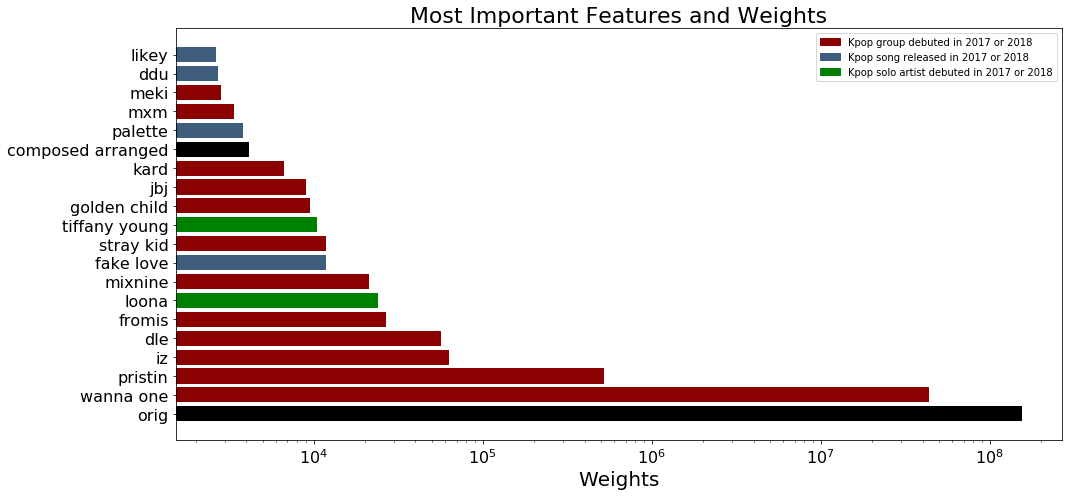

In [20]:
plt.figure(figsize=(15,7))
plt.barh(labels, weights, color=weights_color, log=True)
plt.yticks(fontsize=16);
plt.xticks(fontsize=16);
plt.xlabel('Weights', fontsize=20);
plt.title('Most Important Features and Weights', fontsize=22)
plt.tight_layout()

red_patch = mpatches.Patch(color='#8B0000', label='Kpop group debuted in 2017 or 2018')
blue_patch = mpatches.Patch(color='#3F5D7D', label='Kpop song released in 2017 or 2018')
green_patch = mpatches.Patch(color='green', label='Kpop solo artist debuted in 2017 or 2018')
plt.legend(handles=[red_patch,blue_patch,green_patch]);

The figure shows the ten most important features and weights in the Logistic Regression Classifier. As expected, most of them are Kpop Artists who made their debut in 2017 or 2018. The highest weight is on the word "orig", which is shorten for "original". Let us search the word "orig" in the Kpop Reddit posts.<br>




>![](../img/orig.png)



The word "orig" appeared on the title of dance/song cover video contents which normally indicate the original singer of the song. In the previous years, the dance/song cover videos are usually made by the Kpop fans. In recent years, most of these cover videos are made by Kpop artists themselves that they sing or dance on different Kpop groups' or western pop artists' songs and upload these high quality videos to their official youtube account or other social network website. In this way, Kpop artist especially who just debuted can gain more attention by other Kpop fans and western pop fans.  

The word "composed arranged"is also an important word to distinguish the Reddit post to recent or previous years. K-pop fans in US may didn't pay attention to the composer of the K-pop music most of K-pop artists don't make music, but nowadays, more and more K-pop groups produce their own music to share their message. This could be also a possible reason that BTS's success in US because they were able to produce the music that can make them universal.

In [21]:
raw_text = pd.read_csv('../dataset/raw_text.csv',)

In [22]:
Positive_index = X_test[gs_logit.predict_proba(np.array(X_test))[:,1]>0.7].index
Summary = raw_text.loc[Positive_index,['text','class']][:100]
Misclassification = Summary[Summary['class']==0]

gs_logit.predict_proba(np.array(X_test.loc[Misclassification['text'].index]))

array([[0.19128108, 0.80871892],
       [0.29402446, 0.70597554],
       [0.28844484, 0.71155516],
       [0.01499735, 0.98500265],
       [0.15038058, 0.84961942],
       [0.12280384, 0.87719616],
       [0.12757393, 0.87242607],
       [0.15758614, 0.84241386],
       [0.17725757, 0.82274243],
       [0.17421037, 0.82578963],
       [0.25355142, 0.74644858]])

In [23]:
raw_text.loc[Misclassification['text'].index]['text'].values

array([' Stellar - Sting @ Arirang Kpop ',
       'Ask Reddit comment about Kpop singers being used a prostitutes ',
       'BULLDOK Debut teaser is here to bless us all ', "NU'EST ",
       '2016 Male Idol digital downloads + physical sales ',
       "Which songs were you late to discovering? As we all know there are so many new kpop vids every day that unless you're pharkil or something there's no way to keep up. Most of us only have room for a few biases in our hearts but as a result we miss a lot of great stuff. What songs did you miss as they were being promoted but found later and fell in love with? I'm looking for more potentially missed wonders.\n\nThread inspired by [History - Queen](",
       'EXO Becomes 1st Forgein Act To Get #1 On Oricon Roomie Chart [deleted]',
       '임팩트[IMFACT] 지안&상 눈코입 (Cover) ',
       "Over 100 Artists - National Healing Song 'Abandoned by the Side of the Street(길가에 버려지다)' ",
       'KBS2 뮤직뱅크 (Music Bank) Performances [16.06.10] ---\n---\n\n#**KBS2

The misclassification happened when the post include too little text or too many K-pop artists names. Including the year number in the text may help to improve the model performance. For example, the text like: 

        "2016 Male Idol digital downloads + physical sales "
After preprocessing, the text become:
        
        "male idol digital download physical sale"
However, including the year number may also confuse the model when text body include the year which may irrelevant to the post creation date.

## 2.3 Random Forest

Training the Random Forest model is a time consuming process with this size of data, so we just used the default hyper-parameters. 

In [24]:
start_time = time.time()
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 115.7914490699768 seconds ---


In [25]:
rf.score(X_train,y_train)

0.9691609705400328

In [26]:
rf.score(X_test,y_test)

0.7556434931198849

As expected, the Random Forest model is highly overfitted which is normally the case for the complex structured RandomForest model.

In [27]:
feat_importance = pd.DataFrame(rf.feature_importances_, X_train.columns, columns=['importance'])

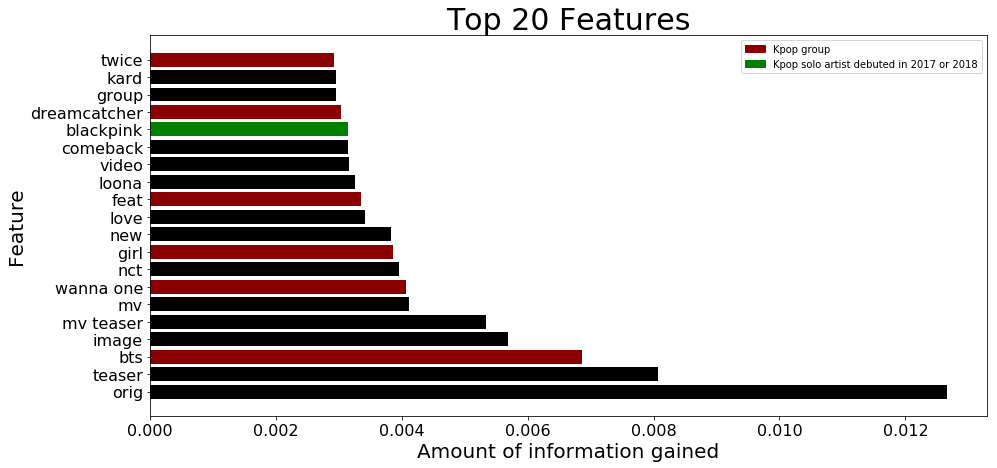

In [28]:
weights_color = ['black','black','#8B0000','black','black','black','#8B0000','black','#8B0000','black','black','#8B0000','black','black','black',
'green','#8B0000','black','black','#8B0000']


plt.figure(figsize=(15,7))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'], color=weights_color)
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

red_patch = mpatches.Patch(color='#8B0000', label='Kpop group')
green_patch = mpatches.Patch(color='green', label='Kpop solo artist debuted in 2017 or 2018')
plt.legend(handles=[red_patch,green_patch]);

Also, the most important feature in the Random Forest model is "orig". Unlike to Logistic Regression, the weights are mostly assigned to the common text instead of Band names. In addition, the Kpop groups in the figure are not all debuted in 2017 and 2018. For example, BTS debuted in 2013 who gained a lot of popularity in recent years, there are posts must exist to mention BTS during 2013 to 2016. However, the group names listed above are definitely the most popular bands in US market right now who are frequently mentioned in the Reddit posts.

# 3. Conclusion

By classifying if the Kpop Reddit post is created in the recent years, we wanted to attempt to retrieve important and trending text features for increasing the influence of Korean culture. 

According to the result of Logistic Regression model, I suggest to Korean Culture Center that Korean Wave phenomenon should keep integrating into a social media-embedded cultural landscape in US. Collaborate with popular Kpop artists like Wanna One, IZ\*One, (G)I-dle etc. who just made their debut in 2017 or 2018, make attractive video contents which can be a cover of other K-pop groups' or western artists' dance or songs and share these videio through social media websites. In addition, Kpop artists should keep trying to compose and produce their own songs for targeting global audiences. 